In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from datetime import datetime, timedelta

C:\Users\dagbo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
start_time = time()

energy_meters_df = pd.read_excel('data/VIS Målere.xlsx')
# Remove leading and trailing whitespace in cells with value of type string
energy_meters_df = energy_meters_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

raw_esave_tables_dict = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', decimal=',', sheet_name=None)
raw_esave_tables_list = raw_esave_tables_dict.values()
for table in raw_esave_tables_list:
    table.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    table['datetime'] = pd.to_datetime(table['datetime'], dayfirst=True)
    table.set_index('datetime', inplace=True)
    table.sort_index()
raw_esave_table = pd.concat(raw_esave_tables_list, axis=1, ignore_index=False)

stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to read xls files')


Used 89.33 seconds to read xls files


In [3]:
energy_meters_df

,Objekt,Navn,Type,Formel,UoM,Målernivå
0,Bygg,Trondheim Kommune - Ranheimsfjæra barnehage,NaN,NaN,NaN,NaN
1,Bygg,Trondheim Kommune - Hesteskoen barnehage,NaN,NaN,NaN,NaN
2,VIS-Måler,Temp middel,Temperatur,Eklima_68860_TAM,°C,Annen måler
3,Bygg,Trondheim Kommune - Torvet,NaN,NaN,NaN,NaN
4,VIS-Måler,Fjernvarme 66217271,Fjernvarme,ESAVE_279829-980396002_EAN,kWh,Forbruksmåler
...,...,...,...,...,...,...
1432,Bygg,Trondheim Kommune - Angelltrøa barnehage,NaN,NaN,NaN,NaN
1433,VIS-Måler,Trondheim Voll,Temperatur,Eklima_68860_TAM,°C,Annen måler
1434,VIS-Måler,Voll TAN,Temperatur,Eklima_68860_TAN,°C,Annen måler
1435,VIS-Måler,Graddager,Graddager,Eklima_68860_GD17,grdg,Annen måler


In [4]:
raw_esave_table

,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN,707057500068789658,707057500068425556,707057500068402960,707057500068104048,707057500068744237,ESAVE_942110464_2_ID,707057500068750269,...,ESAVE_LeaIsh:US05_B_E_MtrH15_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH16_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH2_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH3_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH5_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH6_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH7_CumEg_EAN,707057500068858477,ESAVE_280058-980396002_EAN,ESAVE_942110464_25_ID
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,9.4,7.2,8.0,7.1,4.0,6.7,9.9,14.6,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,120.0,NaN
2015-01-01 01:00:00,9.6,7.2,9.0,7.0,7.0,8.6,10.0,14.6,NaN,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,110.0,NaN
2015-01-01 02:00:00,8.7,7.2,9.0,6.2,6.0,10.4,8.8,15.0,NaN,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,120.0,NaN
2015-01-01 03:00:00,8.8,7.2,9.0,7.8,5.0,10.2,10.2,16.6,NaN,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,120.0,NaN
2015-01-01 04:00:00,9.1,7.2,9.0,7.0,5.0,9.8,9.9,15.4,NaN,18.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,120.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 19:00:00,6.0,3.0,7.0,3.0,7.0,7.0,10.0,16.0,NaN,2.0,...,1.0,223.0,129.0,10.0,40.0,0.0,0.0,101.0,110.0,0.59
2020-01-01 20:00:00,7.0,2.0,6.0,6.0,6.0,7.0,11.0,15.0,NaN,3.0,...,0.0,220.0,129.0,11.0,50.0,0.0,0.0,100.0,130.0,0.59
2020-01-01 21:00:00,6.0,3.0,6.0,4.0,7.0,10.0,11.0,16.0,NaN,2.0,...,0.0,220.0,131.0,12.0,50.0,0.0,0.0,111.0,110.0,0.59


Types of sensors and coresponding unit of measurement:  
'Ikke valgt(Ikke valgt)','Elkjel(kWh)', 'Temperatur(°C)', 'Ikke valgt(°C)', 'Fjernvarme(kWh)', 'Ikke valgt(m/s)', 'Vann(m3)', 'Ikke valgt(kWh)', 'Ikke valgt(timer)', 'Fastkraft(kWh)', 'Virkningsgrad(nan)', 'Kjøling(kWh)', 'Varme(kWh)', 'Virkningsgrad(Ikke valgt)', 'Graddager(grdg)'

In [5]:
start_time = time()

buildings = {}
current_building = None
sensor_types = ['Fastkraft', 'Fjernvarme', 'Varme', 'Elkjel', 'Kjøling']
for _, row in energy_meters_df.iterrows():
    # if current row is a building not a sensor create a new dict to store all sensors for that building
    if row['Objekt'] == 'Bygg':
        current_building = {}
        for sensor_type in sensor_types:
            current_building[sensor_type] = {}
        buildings[row['Navn']] = current_building
        continue
    
    sensor_type = row['Type']
    if sensor_type in sensor_types:
        name = row['Navn']
        sensor_id = row['Formel']
        current_building[sensor_type][name] = sensor_id


stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to parse')

Used 0.05 seconds to parse


In [6]:
# Create a dictionary that contains a dataframe for each building that have column for each sensor type (e.g. Fjernvarme or Fastkraft)
building_dfs = {}
for building_name, sensor_type_dict in buildings.items():

    sensor_type_series = {}
    for sensor_type, sensor_dict in sensor_type_dict.items():
        for sensor_id in sensor_dict.values():
            if sensor_id in raw_esave_table.columns:
                sensor_series = raw_esave_table[sensor_id]
                if not sensor_type in sensor_type_series:
                    sensor_type_series[sensor_type] = sensor_series
                else:
                    sensor_type_series[sensor_type] = sensor_type_series[sensor_type] + sensor_series
    if sensor_type_series:
        building_dfs[building_name] = pd.DataFrame(sensor_type_series)
        building_dfs[building_name].sort_index()

# Create a column in each building dataframe that is the total energy consumption, i.e. the sum of all other columns.
for building_df in building_dfs.values():
    building_df['Totalt'] = building_df[list(building_df.columns)].sum(axis=1)


In [7]:
building_dfs['Trondheim Kommune - Voldsminde barnehage']

,Fastkraft,Fjernvarme,Totalt
datetime,,,
2015-01-01 00:00:00,5.6,19.0,24.6
2015-01-01 01:00:00,6.4,19.0,25.4
2015-01-01 02:00:00,5.4,19.0,24.4
2015-01-01 03:00:00,5.8,19.0,24.8
2015-01-01 04:00:00,5.6,20.0,25.6
...,...,...,...
2020-01-01 19:00:00,9.0,18.0,27.0
2020-01-01 20:00:00,4.0,19.0,23.0
2020-01-01 21:00:00,5.0,19.0,24.0


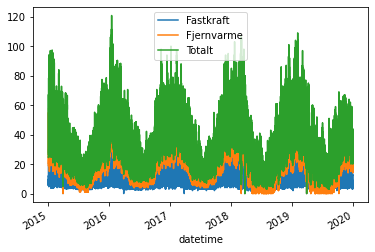

In [8]:
building_dfs['Trondheim Kommune - Voldsminde barnehage'].plot()
plt.show()

In [9]:
# Create new data frames for each building that have values for each day or week instead of hourly
building_daily_dfs = {}
building_weekly_dfs = {}
for building_name, building_df in building_dfs.items():
    building_daily_dfs[building_name] = building_df.resample('D').sum()
    building_weekly_dfs[building_name] = building_df.resample('W-MON').sum()


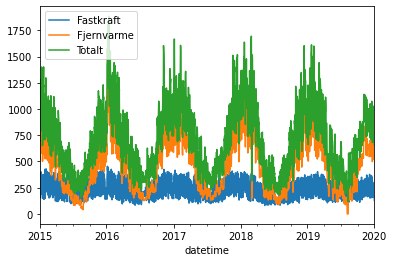

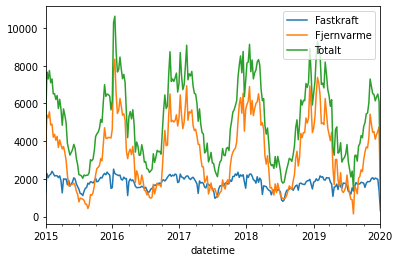

In [10]:
building_daily_dfs['Trondheim Kommune - Voldsminde barnehage'].plot()
plt.show()
building_weekly_dfs['Trondheim Kommune - Voldsminde barnehage'].plot()
plt.show()
